In [2]:
from pandas import read_csv, merge, concat
from geopandas import read_file, sjoin_nearest

from zipfile import ZipFile

### Carga de datos

In [3]:
with ZipFile("data/mza_09_cpv2020.zip") as z: # Censo nivel manzana CDMX
    censo = read_csv(z.open("mza_09_cpv2020.csv"), 
                        dtype={"ENTIDAD":str,"MUN":str,"LOC":str,"AGEB":str,"MZA":str},
                        usecols=["ENTIDAD","MUN","LOC","NOM_LOC","AGEB","MZA","POBTOT"])

censo = censo[~censo.NOM_LOC.str.contains('Total')].reset_index(drop=True)
censo['CVEGEO'] = censo.ENTIDAD + censo.MUN + censo.LOC + censo.AGEB + censo.MZA

In [4]:
cols = read_file('zip://data/colonias_seduvi.zip') # Colonias CDMX

man = read_file('zip://data/manzanas_09.zip/09m.shp', dtype={'CVEGEO':str}).to_crs(cols.crs) # Manzanas CDMX
cas = read_file('zip://data/caserios_09.zip/09cd.shp', dtype={'CVEGEO':str}).to_crs(cols.crs) # Caserio disperso CDMX

### Geoproceso

In [5]:
# Calculamos un punto representativo de la manzana (puede ser el centroide u otro siempre y cuando este dentro del poligono)
cas['geometry'] = cas.representative_point()
man['geometry'] = man.representative_point() 

man = concat([man, cas], ignore_index=True)

cols_man = sjoin_nearest(cols, man, distance_col='dist', how="right") #join espacial!

### Join tabular 

In [6]:
cols_pob = merge(cols_man[['cve_col','colonia','CVEGEO','geometry']],censo[['CVEGEO','POBTOT']], on='CVEGEO') # Agregamos datos censales
cols_pob = cols_pob.groupby(['cve_col','colonia']).POBTOT.sum().reset_index() # Agrupamos por colonia y sumamos

cols = merge(cols, cols_pob, on=['cve_col','colonia']) # Base final

### Visualización

<Axes: >

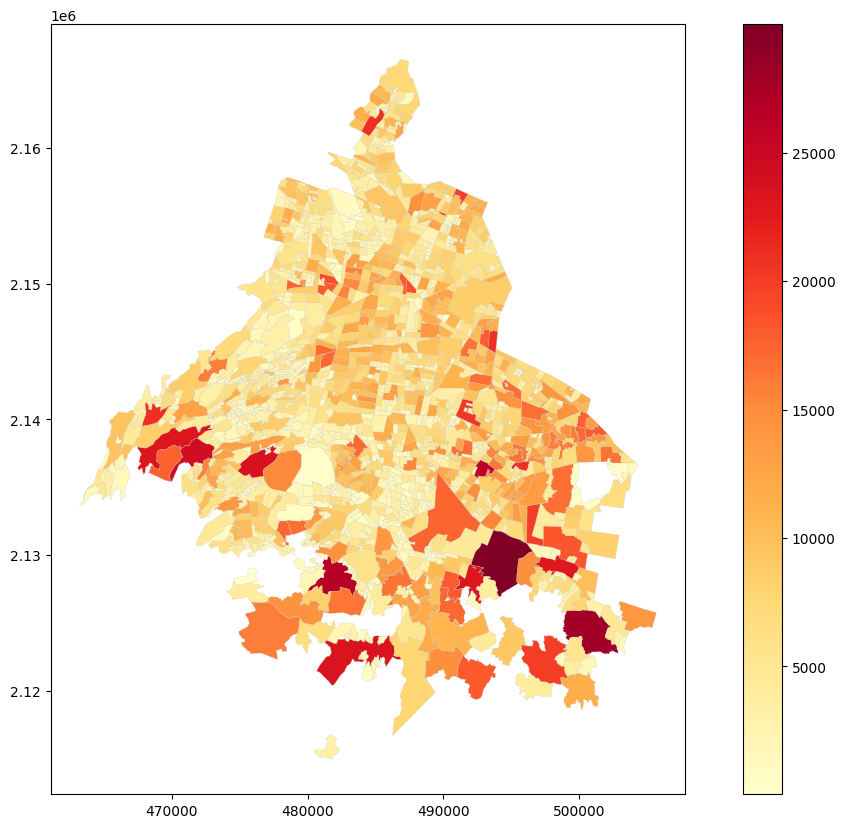

In [7]:
cols.plot(column='POBTOT', cmap='YlOrRd', linewidth=0.2, edgecolor='0.8', legend=True, figsize=(15, 10))

## Comprobación

In [8]:
censo[~censo.CVEGEO.isin(man.CVEGEO)] # Todos los datos del censo fueron utilizados

,ENTIDAD,MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,CVEGEO


In [10]:
censo.POBTOT.sum(), cols.POBTOT.sum(), cols.pob_2010.sum() # La suma coincide perfectamente!

(9145590, 9145590, 8836815.0)